# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16489644573210373648, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 272564224
 locality {
   bus_id: 1
 }
 incarnation: 15998549066590472717
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"]

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatened_layers = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    separable_layer = separable_conv2d_batchnorm(concatened_layers, filters, 1)
    output_layer = separable_conv2d_batchnorm(separable_layer, filters, 1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    print("Features Layer", inputs.shape)
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1_layer = encoder_block(inputs, 32, 2)
    encoder_2_layer = encoder_block(encoder_1_layer, 64, 2)
    encoder_3_layer = encoder_block(encoder_2_layer, 128, 2)
    print("Encoder 1", encoder_1_layer.shape)
    print("Encoder 2", encoder_2_layer.shape)
    print("Encoder 3", encoder_3_layer.shape)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1_1_layer = conv2d_batchnorm(encoder_3_layer, 128, 1, 1)
    print("1x1 Conv", conv_1_1_layer.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1_layer = decoder_block(conv_1_1_layer, encoder_2_layer, 128)
    print("Decoder 1", decoder_1_layer.shape)
    decoder_2_layer = decoder_block(decoder_1_layer, encoder_1_layer, 64)
    print("Decoder 2", decoder_2_layer.shape)
    decoder_3_layer = decoder_block(decoder_2_layer, inputs, 32)
    print("Decoder 3", decoder_2_layer.shape)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    output_layer = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_3_layer)
    print("Output Layer", output_layer.shape)
    
    return output_layer

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [66]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 30
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)
workers = 1 # Using GPU.

Epoch 1/30
128/128 [==============================] - 58s - loss: 0.0090 - val_loss: 0.0280
Epoch 2/30
128/128 [==============================] - 55s - loss: 0.0092 - val_loss: 0.0291
Epoch 3/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0286
Epoch 4/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0198
Epoch 5/30
127/128 [============================>.] - ETA: 0s - loss: 0.0090

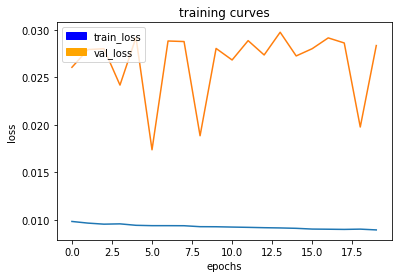

128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0283
Epoch 6/30
128/128 [==============================] - 55s - loss: 0.0091 - val_loss: 0.0279
Epoch 7/30
128/128 [==============================] - 56s - loss: 0.0088 - val_loss: 0.0300
Epoch 8/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0271
Epoch 9/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0320
Epoch 10/30
127/128 [============================>.] - ETA: 0s - loss: 0.0090

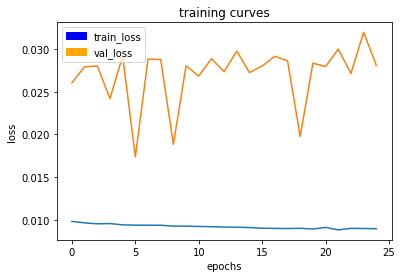

128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0281
Epoch 11/30
128/128 [==============================] - 55s - loss: 0.0089 - val_loss: 0.0306
Epoch 12/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0148
Epoch 13/30
128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0296
Epoch 14/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0298
Epoch 15/30
127/128 [============================>.] - ETA: 0s - loss: 0.0090

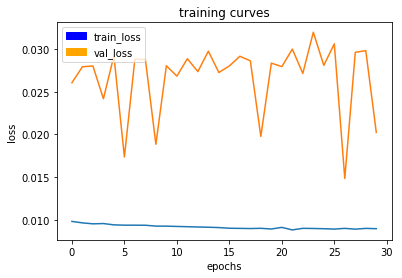

128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0202
Epoch 16/30
128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0285
Epoch 17/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0266
Epoch 18/30
128/128 [==============================] - 56s - loss: 0.0091 - val_loss: 0.0319
Epoch 19/30
128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0282
Epoch 20/30
127/128 [============================>.] - ETA: 0s - loss: 0.0090

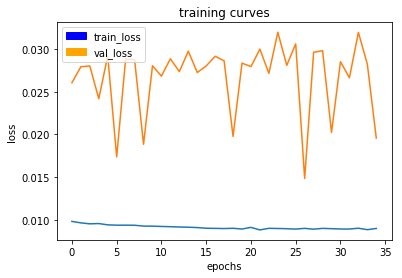

128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0196
Epoch 21/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0392
Epoch 22/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0189
Epoch 23/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0294
Epoch 24/30
128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0268
Epoch 25/30
127/128 [============================>.] - ETA: 0s - loss: 0.0089

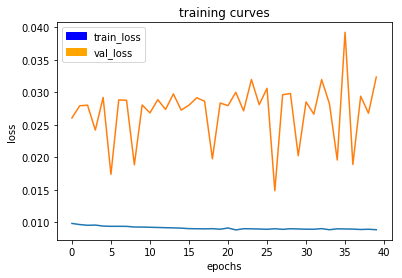

128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0323
Epoch 26/30
128/128 [==============================] - 56s - loss: 0.0091 - val_loss: 0.0293
Epoch 27/30
128/128 [==============================] - 56s - loss: 0.0090 - val_loss: 0.0195
Epoch 28/30
128/128 [==============================] - 56s - loss: 0.0088 - val_loss: 0.0280
Epoch 29/30
128/128 [==============================] - 55s - loss: 0.0090 - val_loss: 0.0372
Epoch 30/30
127/128 [============================>.] - ETA: 0s - loss: 0.0089

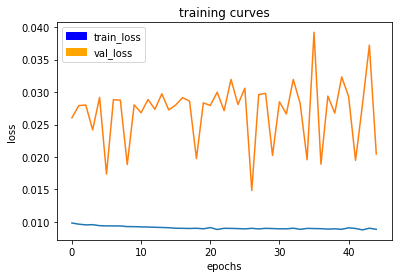

128/128 [==============================] - 56s - loss: 0.0089 - val_loss: 0.0205
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.996377766888104
average intersection over union for other people is 0.4061888271351981
average intersection over union for the hero is 0.923793979887562
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9891215097137955
average intersection over union for other people is 0.780752813393771
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 53, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969679997403453
average intersection over union for other people is 0.4846831156382445


In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
#model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

#logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)
score_all()

In [68]:
# Save your trained model weights
weight_file_name = 'model_weights-5-2-145'
model_tools.save_network(model, weight_file_name)
#score_all()

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)
Epoch 1/40
128/128 [==============================] - 57s - loss: 0.1707 - val_loss: 0.1162
Epoch 2/40
128/128 [==============================] - 56s - loss: 0.0420 - val_loss: 0.1390
Epoch 3/40
128/128 [==============================] - 56s - loss: 0.0382 - val_loss: 0.0858
Epoch 4/40
128/128 [==============================] - 56s - loss: 0.0375 - val_loss: 0.0674
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0326

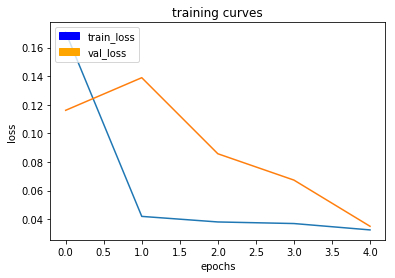

128/128 [==============================] - 56s - loss: 0.0326 - val_loss: 0.0351
Epoch 6/40
128/128 [==============================] - 56s - loss: 0.0301 - val_loss: 0.0355
Epoch 7/40
128/128 [==============================] - 56s - loss: 0.0299 - val_loss: 0.0456
Epoch 8/40
128/128 [==============================] - 56s - loss: 0.0268 - val_loss: 0.0417
Epoch 9/40
128/128 [==============================] - 56s - loss: 0.0270 - val_loss: 0.0435
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0252

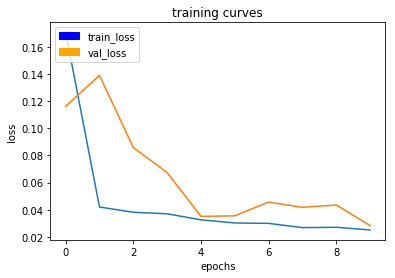

128/128 [==============================] - 56s - loss: 0.0251 - val_loss: 0.0283
Epoch 11/40
128/128 [==============================] - 56s - loss: 0.0280 - val_loss: 0.0406
Epoch 12/40
128/128 [==============================] - 56s - loss: 0.0243 - val_loss: 0.0419
Epoch 13/40
128/128 [==============================] - 56s - loss: 0.0237 - val_loss: 0.0343
Epoch 14/40
128/128 [==============================] - 56s - loss: 0.0219 - val_loss: 0.0352
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0219

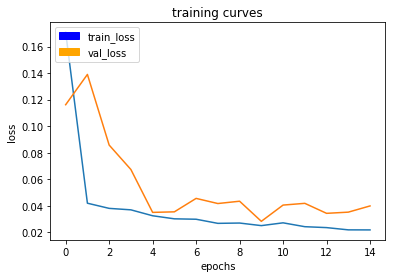

128/128 [==============================] - 56s - loss: 0.0219 - val_loss: 0.0399
Epoch 16/40
128/128 [==============================] - 56s - loss: 0.0201 - val_loss: 0.0452
Epoch 17/40
128/128 [==============================] - 56s - loss: 0.0227 - val_loss: 0.0337
Epoch 18/40
128/128 [==============================] - 56s - loss: 0.0201 - val_loss: 0.0340
Epoch 19/40
128/128 [==============================] - 56s - loss: 0.0178 - val_loss: 0.0308
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0215

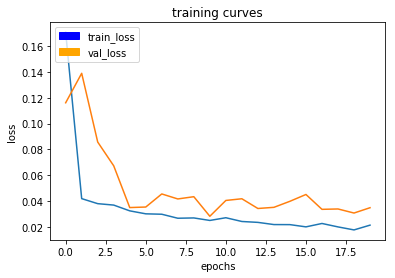

128/128 [==============================] - 56s - loss: 0.0215 - val_loss: 0.0349
Epoch 21/40
128/128 [==============================] - 56s - loss: 0.0197 - val_loss: 0.0346
Epoch 22/40
128/128 [==============================] - 56s - loss: 0.0179 - val_loss: 0.0305
Epoch 23/40
128/128 [==============================] - 56s - loss: 0.0182 - val_loss: 0.0218
Epoch 24/40
128/128 [==============================] - 56s - loss: 0.0182 - val_loss: 0.0804
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0184

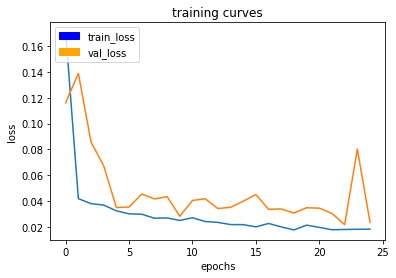

128/128 [==============================] - 56s - loss: 0.0184 - val_loss: 0.0236
Epoch 26/40
128/128 [==============================] - 56s - loss: 0.0157 - val_loss: 0.0296
Epoch 27/40
128/128 [==============================] - 56s - loss: 0.0179 - val_loss: 0.0531
Epoch 28/40
128/128 [==============================] - 56s - loss: 0.0168 - val_loss: 0.0310
Epoch 29/40
128/128 [==============================] - 56s - loss: 0.0153 - val_loss: 0.0265
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0164

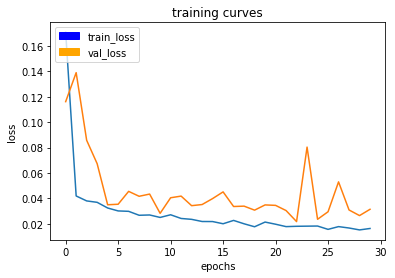

128/128 [==============================] - 56s - loss: 0.0164 - val_loss: 0.0315
Epoch 31/40
128/128 [==============================] - 56s - loss: 0.0174 - val_loss: 0.0296
Epoch 32/40
128/128 [==============================] - 56s - loss: 0.0174 - val_loss: 0.0307
Epoch 33/40
128/128 [==============================] - 56s - loss: 0.0153 - val_loss: 0.0245
Epoch 34/40
128/128 [==============================] - 56s - loss: 0.0152 - val_loss: 0.0237
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0140

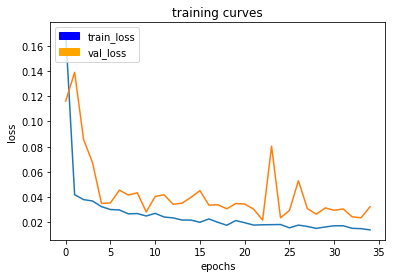

128/128 [==============================] - 56s - loss: 0.0140 - val_loss: 0.0324
Epoch 36/40
128/128 [==============================] - 56s - loss: 0.0135 - val_loss: 0.0265
Epoch 37/40
128/128 [==============================] - 56s - loss: 0.0149 - val_loss: 0.0349
Epoch 38/40
128/128 [==============================] - 56s - loss: 0.0159 - val_loss: 0.0344
Epoch 39/40
128/128 [==============================] - 56s - loss: 0.0148 - val_loss: 0.0198
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0146

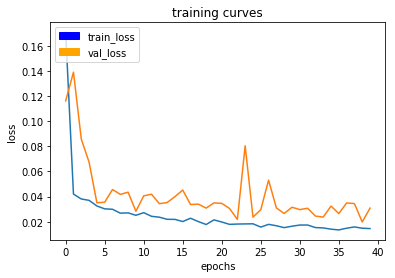

128/128 [==============================] - 56s - loss: 0.0146 - val_loss: 0.0308
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954994654708705
average intersection over union for other people is 0.3080400138454611
average intersection over union for the hero is 0.8556923793307327
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9840486365205556
average intersection over union for other people is 0.6688262378711686
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 9, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964745098132034
average intersection over union for other people is 0.401452816280289

In [84]:
# Run One
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.01
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-1'
model_tools.save_network(model, weight_file_name)
score_all()

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)
Epoch 1/40
128/128 [==============================] - 58s - loss: 0.7140 - val_loss: 0.2985
Epoch 2/40
128/128 [==============================] - 56s - loss: 0.1422 - val_loss: 0.1178
Epoch 3/40
128/128 [==============================] - 57s - loss: 0.0736 - val_loss: 0.1007
Epoch 4/40
128/128 [==============================] - 56s - loss: 0.0515 - val_loss: 0.0784
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0425

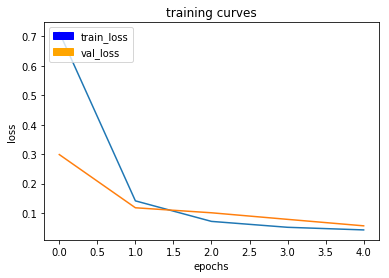

128/128 [==============================] - 57s - loss: 0.0425 - val_loss: 0.0564
Epoch 6/40
128/128 [==============================] - 56s - loss: 0.0390 - val_loss: 0.0467
Epoch 7/40
128/128 [==============================] - 56s - loss: 0.0343 - val_loss: 0.0415
Epoch 8/40
128/128 [==============================] - 56s - loss: 0.0364 - val_loss: 0.0404
Epoch 9/40
128/128 [==============================] - 57s - loss: 0.0304 - val_loss: 0.0366
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0324

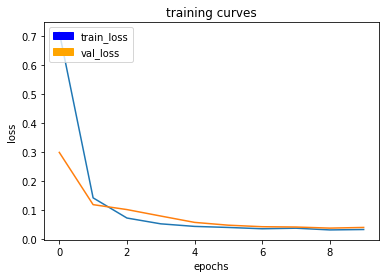

128/128 [==============================] - 57s - loss: 0.0323 - val_loss: 0.0390
Epoch 11/40
128/128 [==============================] - 56s - loss: 0.0296 - val_loss: 0.0357
Epoch 12/40
128/128 [==============================] - 56s - loss: 0.0282 - val_loss: 0.0306
Epoch 13/40
128/128 [==============================] - 57s - loss: 0.0260 - val_loss: 0.0382
Epoch 14/40
128/128 [==============================] - 56s - loss: 0.0263 - val_loss: 0.0331
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0272

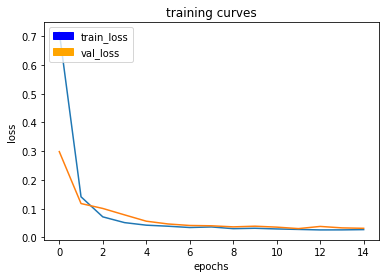

128/128 [==============================] - 57s - loss: 0.0271 - val_loss: 0.0316
Epoch 16/40
128/128 [==============================] - 57s - loss: 0.0232 - val_loss: 0.0283
Epoch 17/40
128/128 [==============================] - 57s - loss: 0.0224 - val_loss: 0.0352
Epoch 18/40
128/128 [==============================] - 56s - loss: 0.0228 - val_loss: 0.0349
Epoch 19/40
128/128 [==============================] - 57s - loss: 0.0210 - val_loss: 0.0320
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0219

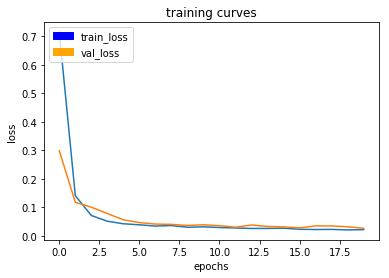

128/128 [==============================] - 56s - loss: 0.0218 - val_loss: 0.0268
Epoch 21/40
128/128 [==============================] - 57s - loss: 0.0193 - val_loss: 0.0313
Epoch 22/40
128/128 [==============================] - 56s - loss: 0.0218 - val_loss: 0.0286
Epoch 23/40
128/128 [==============================] - 56s - loss: 0.0200 - val_loss: 0.0229
Epoch 24/40
128/128 [==============================] - 56s - loss: 0.0189 - val_loss: 0.0269
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0202

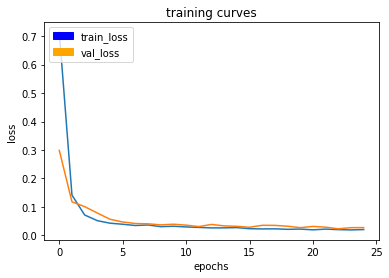

128/128 [==============================] - 57s - loss: 0.0202 - val_loss: 0.0271
Epoch 26/40
128/128 [==============================] - 56s - loss: 0.0184 - val_loss: 0.0300
Epoch 27/40
128/128 [==============================] - 57s - loss: 0.0203 - val_loss: 0.0321
Epoch 28/40
128/128 [==============================] - 57s - loss: 0.0184 - val_loss: 0.0257
Epoch 29/40
128/128 [==============================] - 57s - loss: 0.0184 - val_loss: 0.0258
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0175

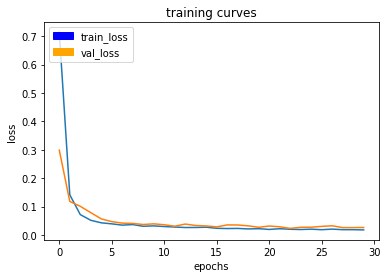

128/128 [==============================] - 57s - loss: 0.0176 - val_loss: 0.0261
Epoch 31/40
128/128 [==============================] - 57s - loss: 0.0176 - val_loss: 0.0276
Epoch 32/40
128/128 [==============================] - 56s - loss: 0.0162 - val_loss: 0.0188
Epoch 33/40
128/128 [==============================] - 57s - loss: 0.0213 - val_loss: 0.0483
Epoch 34/40
128/128 [==============================] - 58s - loss: 0.0184 - val_loss: 0.0203
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0189

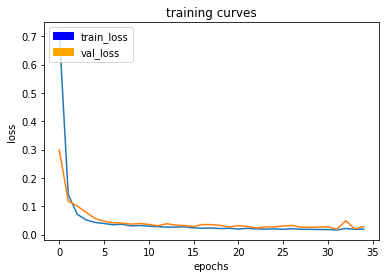

128/128 [==============================] - 58s - loss: 0.0189 - val_loss: 0.0278
Epoch 36/40
128/128 [==============================] - 58s - loss: 0.0168 - val_loss: 0.0294
Epoch 37/40
128/128 [==============================] - 58s - loss: 0.0164 - val_loss: 0.0246
Epoch 38/40
128/128 [==============================] - 58s - loss: 0.0166 - val_loss: 0.0282
Epoch 39/40
128/128 [==============================] - 57s - loss: 0.0164 - val_loss: 0.0299
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0159

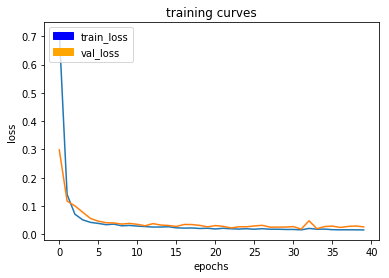

128/128 [==============================] - 58s - loss: 0.0159 - val_loss: 0.0265
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9952808581144688
average intersection over union for other people is 0.3538603238047217
average intersection over union for the hero is 0.9141327082766185
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9876811909358482
average intersection over union for other people is 0.7446516961654124
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 71, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964437089303407
average intersection over union for other people is 0.44189849458060

In [85]:
# Run Two
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-2'
model_tools.save_network(model, weight_file_name)
score_all()

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)
Epoch 1/40
128/128 [==============================] - 59s - loss: 1.1764 - val_loss: 0.8662
Epoch 2/40
128/128 [==============================] - 56s - loss: 0.9073 - val_loss: 0.6751
Epoch 3/40
128/128 [==============================] - 56s - loss: 0.7568 - val_loss: 0.5434
Epoch 4/40
128/128 [==============================] - 56s - loss: 0.6374 - val_loss: 0.4395
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.5373

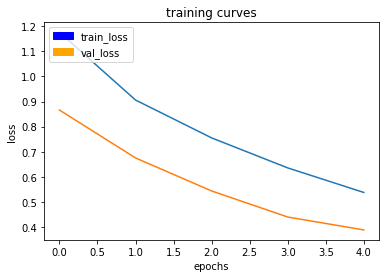

128/128 [==============================] - 56s - loss: 0.5372 - val_loss: 0.3880
Epoch 6/40
128/128 [==============================] - 56s - loss: 0.4523 - val_loss: 0.3601
Epoch 7/40
128/128 [==============================] - 56s - loss: 0.3798 - val_loss: 0.3214
Epoch 8/40
128/128 [==============================] - 56s - loss: 0.3178 - val_loss: 0.2795
Epoch 9/40
128/128 [==============================] - 56s - loss: 0.2682 - val_loss: 0.2432
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.2269

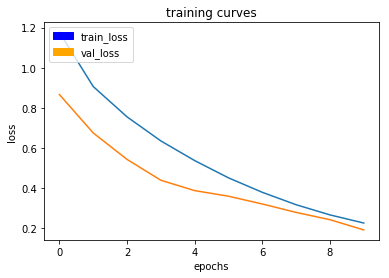

128/128 [==============================] - 56s - loss: 0.2269 - val_loss: 0.1924
Epoch 11/40
128/128 [==============================] - 56s - loss: 0.1966 - val_loss: 0.1738
Epoch 12/40
128/128 [==============================] - 56s - loss: 0.1660 - val_loss: 0.1489
Epoch 13/40
128/128 [==============================] - 56s - loss: 0.1472 - val_loss: 0.1362
Epoch 14/40
128/128 [==============================] - 56s - loss: 0.1470 - val_loss: 0.1302
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.1191

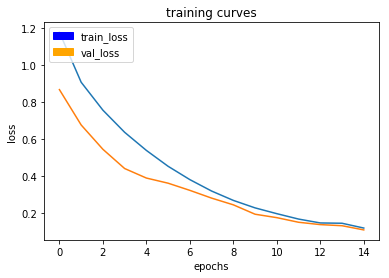

128/128 [==============================] - 56s - loss: 0.1191 - val_loss: 0.1075
Epoch 16/40
128/128 [==============================] - 56s - loss: 0.1045 - val_loss: 0.1058
Epoch 17/40
128/128 [==============================] - 56s - loss: 0.0963 - val_loss: 0.0945
Epoch 18/40
128/128 [==============================] - 56s - loss: 0.0859 - val_loss: 0.0821
Epoch 19/40
128/128 [==============================] - 56s - loss: 0.0823 - val_loss: 0.0813
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0750

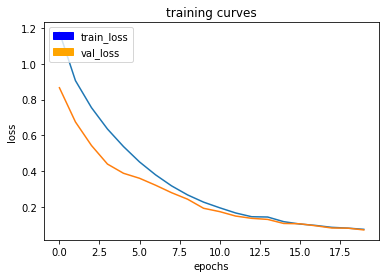

128/128 [==============================] - 56s - loss: 0.0749 - val_loss: 0.0714
Epoch 21/40
128/128 [==============================] - 56s - loss: 0.0702 - val_loss: 0.0774
Epoch 22/40
128/128 [==============================] - 56s - loss: 0.0660 - val_loss: 0.0604
Epoch 23/40
128/128 [==============================] - 56s - loss: 0.0620 - val_loss: 0.0742
Epoch 24/40
128/128 [==============================] - 56s - loss: 0.0598 - val_loss: 0.0553
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0558

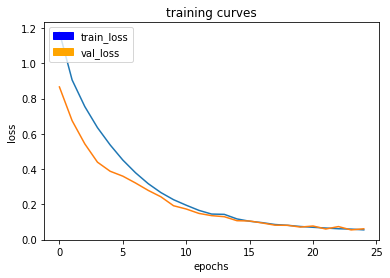

128/128 [==============================] - 56s - loss: 0.0558 - val_loss: 0.0617
Epoch 26/40
128/128 [==============================] - 56s - loss: 0.0541 - val_loss: 0.0573
Epoch 27/40
128/128 [==============================] - 56s - loss: 0.0530 - val_loss: 0.0536
Epoch 28/40
128/128 [==============================] - 56s - loss: 0.0504 - val_loss: 0.0616
Epoch 29/40
128/128 [==============================] - 56s - loss: 0.0481 - val_loss: 0.0579
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0509

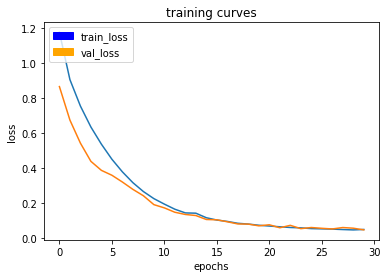

128/128 [==============================] - 56s - loss: 0.0509 - val_loss: 0.0483
Epoch 31/40
128/128 [==============================] - 56s - loss: 0.0449 - val_loss: 0.0542
Epoch 32/40
128/128 [==============================] - 56s - loss: 0.0455 - val_loss: 0.0486
Epoch 33/40
128/128 [==============================] - 56s - loss: 0.0435 - val_loss: 0.0523
Epoch 34/40
128/128 [==============================] - 56s - loss: 0.0434 - val_loss: 0.0498
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0407

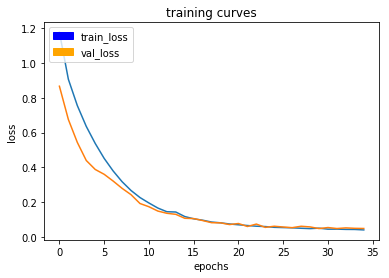

128/128 [==============================] - 56s - loss: 0.0407 - val_loss: 0.0488
Epoch 36/40
128/128 [==============================] - 56s - loss: 0.0396 - val_loss: 0.0514
Epoch 37/40
128/128 [==============================] - 56s - loss: 0.0505 - val_loss: 0.0541
Epoch 38/40
128/128 [==============================] - 56s - loss: 0.0426 - val_loss: 0.0471
Epoch 39/40
128/128 [==============================] - 56s - loss: 0.0402 - val_loss: 0.0510
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0395

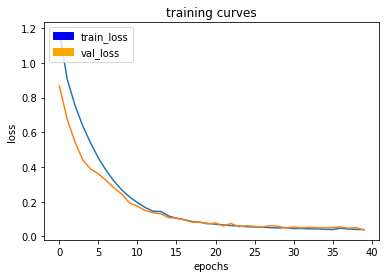

128/128 [==============================] - 56s - loss: 0.0395 - val_loss: 0.0372
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9917587720556258
average intersection over union for other people is 0.20261086910121406
average intersection over union for the hero is 0.784069477941904
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9744425497824605
average intersection over union for other people is 0.46666786810789507
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 46, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.994327745268771
average intersection over union for other people is 0.28391368394420

In [87]:
# Run Three
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.0001
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-3'
model_tools.save_network(model, weight_file_name)
score_all()

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)
Epoch 1/100
128/128 [==============================] - 57s - loss: 0.1668 - val_loss: 0.1123
Epoch 2/100
128/128 [==============================] - 57s - loss: 0.0439 - val_loss: 0.0991
Epoch 3/100
128/128 [==============================] - 55s - loss: 0.0423 - val_loss: 0.0951
Epoch 4/100
128/128 [==============================] - 56s - loss: 0.0355 - val_loss: 0.0591
Epoch 5/100
127/128 [============================>.] - ETA: 0s - loss: 0.0339

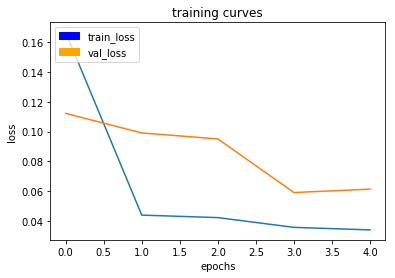

128/128 [==============================] - 55s - loss: 0.0339 - val_loss: 0.0613
Epoch 6/100
128/128 [==============================] - 55s - loss: 0.0324 - val_loss: 0.0480
Epoch 7/100
128/128 [==============================] - 55s - loss: 0.0303 - val_loss: 0.0399
Epoch 8/100
128/128 [==============================] - 55s - loss: 0.0297 - val_loss: 0.0614
Epoch 9/100
128/128 [==============================] - 55s - loss: 0.0276 - val_loss: 0.0386
Epoch 10/100
127/128 [============================>.] - ETA: 0s - loss: 0.0271

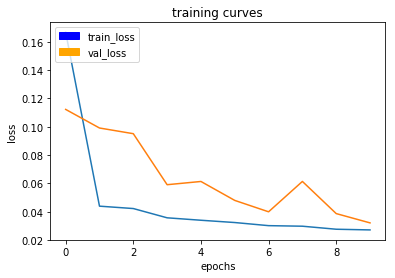

128/128 [==============================] - 55s - loss: 0.0271 - val_loss: 0.0321
Epoch 11/100
128/128 [==============================] - 55s - loss: 0.0260 - val_loss: 0.0412
Epoch 12/100
128/128 [==============================] - 55s - loss: 0.0461 - val_loss: 0.0742
Epoch 13/100
128/128 [==============================] - 55s - loss: 0.0324 - val_loss: 0.0416
Epoch 14/100
128/128 [==============================] - 55s - loss: 0.0273 - val_loss: 0.0402
Epoch 15/100
127/128 [============================>.] - ETA: 0s - loss: 0.0258

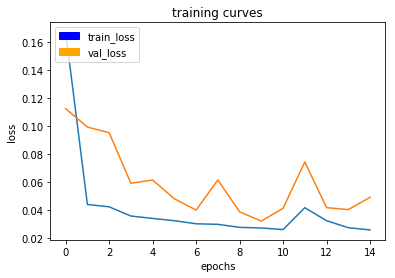

128/128 [==============================] - 55s - loss: 0.0258 - val_loss: 0.0490
Epoch 16/100
128/128 [==============================] - 55s - loss: 0.0250 - val_loss: 0.0315
Epoch 17/100
128/128 [==============================] - 55s - loss: 0.0232 - val_loss: 0.0308
Epoch 18/100
128/128 [==============================] - 55s - loss: 0.0234 - val_loss: 0.0444
Epoch 19/100
128/128 [==============================] - 55s - loss: 0.0221 - val_loss: 0.0403
Epoch 20/100
127/128 [============================>.] - ETA: 0s - loss: 0.0225

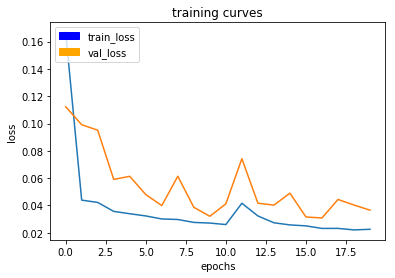

128/128 [==============================] - 55s - loss: 0.0225 - val_loss: 0.0366
Epoch 21/100
128/128 [==============================] - 55s - loss: 0.0213 - val_loss: 0.0258
Epoch 22/100
128/128 [==============================] - 55s - loss: 0.0197 - val_loss: 0.0328
Epoch 23/100
128/128 [==============================] - 55s - loss: 0.0196 - val_loss: 0.0305
Epoch 24/100
128/128 [==============================] - 56s - loss: 0.0206 - val_loss: 0.0313
Epoch 25/100
127/128 [============================>.] - ETA: 0s - loss: 0.0201

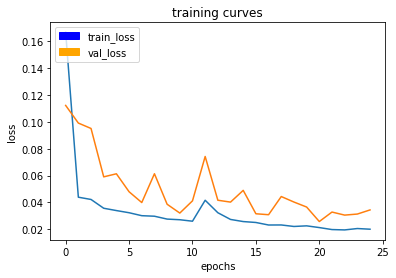

128/128 [==============================] - 58s - loss: 0.0200 - val_loss: 0.0344
Epoch 26/100
128/128 [==============================] - 56s - loss: 0.0194 - val_loss: 0.0275
Epoch 27/100
128/128 [==============================] - 56s - loss: 0.0182 - val_loss: 0.0335
Epoch 28/100
128/128 [==============================] - 57s - loss: 0.0212 - val_loss: 0.0321
Epoch 29/100
128/128 [==============================] - 57s - loss: 0.0179 - val_loss: 0.0300
Epoch 30/100
127/128 [============================>.] - ETA: 0s - loss: 0.0175

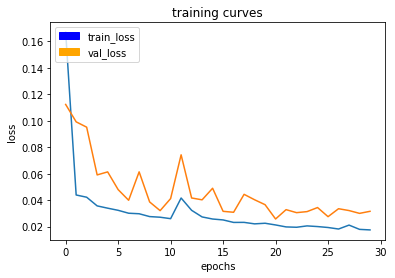

128/128 [==============================] - 58s - loss: 0.0175 - val_loss: 0.0316
Epoch 31/100
128/128 [==============================] - 56s - loss: 0.0184 - val_loss: 0.0304
Epoch 32/100
128/128 [==============================] - 55s - loss: 0.0156 - val_loss: 0.0297
Epoch 33/100
128/128 [==============================] - 55s - loss: 0.0184 - val_loss: 0.0309
Epoch 34/100
128/128 [==============================] - 55s - loss: 0.0180 - val_loss: 0.0566
Epoch 35/100
127/128 [============================>.] - ETA: 0s - loss: 0.0161

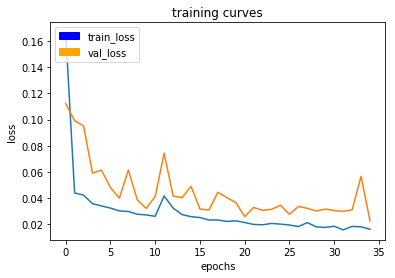

128/128 [==============================] - 55s - loss: 0.0160 - val_loss: 0.0224
Epoch 36/100
128/128 [==============================] - 55s - loss: 0.0189 - val_loss: 0.0332
Epoch 37/100
128/128 [==============================] - 55s - loss: 0.0161 - val_loss: 0.0301
Epoch 38/100
128/128 [==============================] - 55s - loss: 0.0162 - val_loss: 0.0380
Epoch 39/100
128/128 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0273
Epoch 40/100
127/128 [============================>.] - ETA: 0s - loss: 0.0167

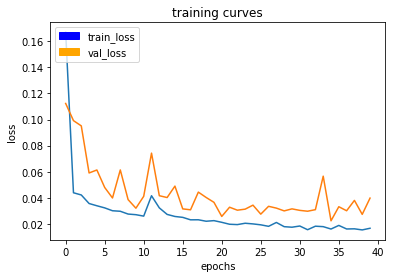

128/128 [==============================] - 55s - loss: 0.0167 - val_loss: 0.0398
Epoch 41/100
128/128 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0185
Epoch 42/100
128/128 [==============================] - 55s - loss: 0.0159 - val_loss: 0.0350
Epoch 43/100
128/128 [==============================] - 56s - loss: 0.0149 - val_loss: 0.0323
Epoch 44/100
128/128 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0296
Epoch 45/100
127/128 [============================>.] - ETA: 0s - loss: 0.0152

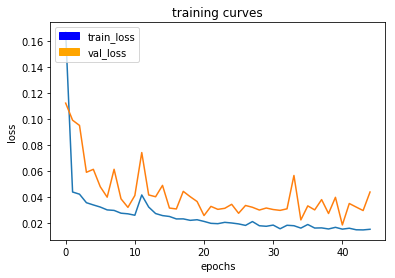

128/128 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0439
Epoch 46/100
128/128 [==============================] - 55s - loss: 0.0148 - val_loss: 0.0231
Epoch 47/100
128/128 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0391
Epoch 48/100
128/128 [==============================] - 55s - loss: 0.0158 - val_loss: 0.0200
Epoch 49/100
128/128 [==============================] - 57s - loss: 0.0150 - val_loss: 0.0314
Epoch 50/100
127/128 [============================>.] - ETA: 0s - loss: 0.0164

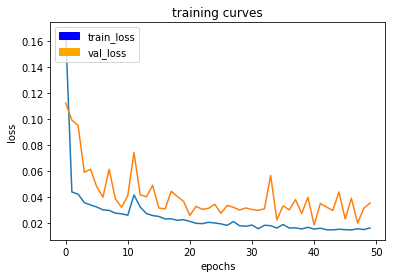

128/128 [==============================] - 56s - loss: 0.0164 - val_loss: 0.0354
Epoch 51/100
128/128 [==============================] - 55s - loss: 0.0161 - val_loss: 0.0314
Epoch 52/100
128/128 [==============================] - 56s - loss: 0.0145 - val_loss: 0.0199
Epoch 53/100
128/128 [==============================] - 57s - loss: 0.0146 - val_loss: 0.0304
Epoch 54/100
128/128 [==============================] - 57s - loss: 0.0182 - val_loss: 0.7551
Epoch 55/100
127/128 [============================>.] - ETA: 0s - loss: 0.0245

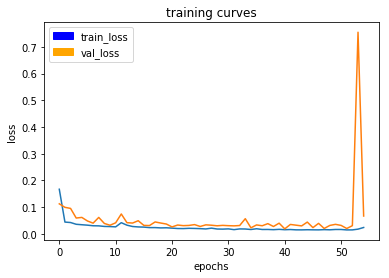

128/128 [==============================] - 58s - loss: 0.0244 - val_loss: 0.0666
Epoch 56/100
128/128 [==============================] - 55s - loss: 0.0202 - val_loss: 0.0230
Epoch 57/100
128/128 [==============================] - 56s - loss: 0.0151 - val_loss: 0.0281
Epoch 58/100
128/128 [==============================] - 55s - loss: 0.0150 - val_loss: 0.0196
Epoch 59/100
128/128 [==============================] - 55s - loss: 0.0140 - val_loss: 0.0284
Epoch 60/100
127/128 [============================>.] - ETA: 0s - loss: 0.0155

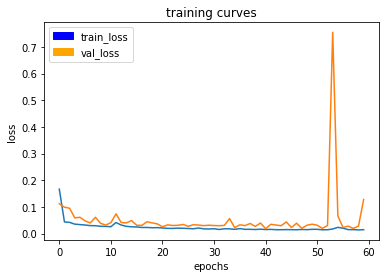

128/128 [==============================] - 55s - loss: 0.0156 - val_loss: 0.1279
Epoch 61/100
128/128 [==============================] - 55s - loss: 0.0198 - val_loss: 0.0585
Epoch 62/100
128/128 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0317
Epoch 63/100
128/128 [==============================] - 55s - loss: 0.0140 - val_loss: 0.0286
Epoch 64/100
128/128 [==============================] - 55s - loss: 0.0141 - val_loss: 0.0258
Epoch 65/100
127/128 [============================>.] - ETA: 0s - loss: 0.0129

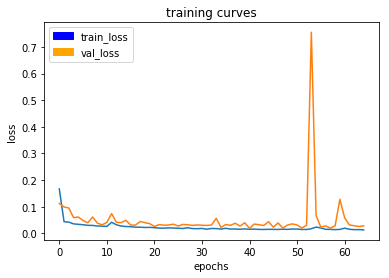

128/128 [==============================] - 55s - loss: 0.0129 - val_loss: 0.0282
Epoch 66/100
128/128 [==============================] - 55s - loss: 0.0135 - val_loss: 0.0282
Epoch 67/100
128/128 [==============================] - 55s - loss: 0.0127 - val_loss: 0.0296
Epoch 68/100
128/128 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0348
Epoch 69/100
128/128 [==============================] - 55s - loss: 0.0142 - val_loss: 0.0330
Epoch 70/100
127/128 [============================>.] - ETA: 0s - loss: 0.0141

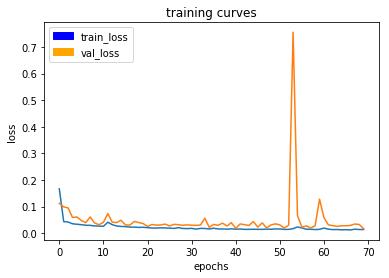

128/128 [==============================] - 56s - loss: 0.0140 - val_loss: 0.0172
Epoch 71/100
128/128 [==============================] - 55s - loss: 0.0118 - val_loss: 0.0284
Epoch 72/100
128/128 [==============================] - 55s - loss: 0.0113 - val_loss: 0.0271
Epoch 73/100
128/128 [==============================] - 55s - loss: 0.0118 - val_loss: 0.0229
Epoch 74/100
128/128 [==============================] - 55s - loss: 0.0115 - val_loss: 0.0271
Epoch 75/100
127/128 [============================>.] - ETA: 0s - loss: 0.0141

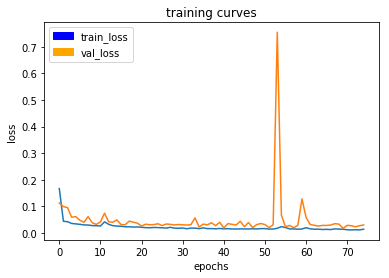

128/128 [==============================] - 56s - loss: 0.0141 - val_loss: 0.0299
Epoch 76/100
128/128 [==============================] - 55s - loss: 0.0117 - val_loss: 0.0289
Epoch 77/100
128/128 [==============================] - 55s - loss: 0.0116 - val_loss: 0.0268
Epoch 78/100
128/128 [==============================] - 56s - loss: 0.0123 - val_loss: 0.0282
Epoch 79/100
128/128 [==============================] - 55s - loss: 0.0110 - val_loss: 0.0175
Epoch 80/100
127/128 [============================>.] - ETA: 0s - loss: 0.0116

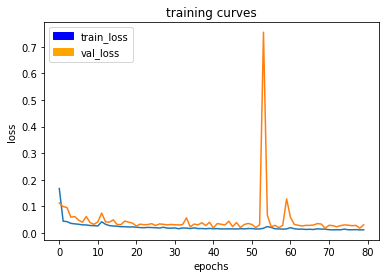

128/128 [==============================] - 55s - loss: 0.0116 - val_loss: 0.0302
Epoch 81/100
128/128 [==============================] - 55s - loss: 0.0107 - val_loss: 0.0188
Epoch 82/100
128/128 [==============================] - 55s - loss: 0.0105 - val_loss: 0.0336
Epoch 83/100
128/128 [==============================] - 55s - loss: 0.0127 - val_loss: 0.0340
Epoch 84/100
128/128 [==============================] - 55s - loss: 0.0129 - val_loss: 0.0313
Epoch 85/100
127/128 [============================>.] - ETA: 0s - loss: 0.0120

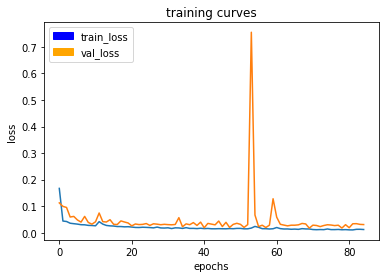

128/128 [==============================] - 55s - loss: 0.0120 - val_loss: 0.0306
Epoch 86/100
128/128 [==============================] - 55s - loss: 0.0107 - val_loss: 0.0166
Epoch 87/100
128/128 [==============================] - 55s - loss: 0.0108 - val_loss: 0.0192
Epoch 88/100
128/128 [==============================] - 55s - loss: 0.0116 - val_loss: 0.0616
Epoch 89/100
128/128 [==============================] - 55s - loss: 0.0131 - val_loss: 0.0348
Epoch 90/100
127/128 [============================>.] - ETA: 0s - loss: 0.0133

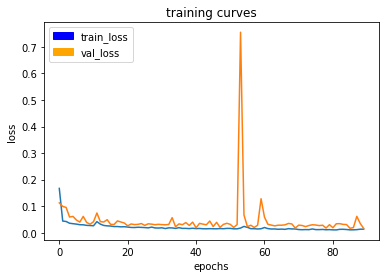

128/128 [==============================] - 55s - loss: 0.0133 - val_loss: 0.0161
Epoch 91/100
128/128 [==============================] - 55s - loss: 0.0131 - val_loss: 0.0310
Epoch 92/100
128/128 [==============================] - 55s - loss: 0.0149 - val_loss: 0.0305
Epoch 93/100
128/128 [==============================] - 55s - loss: 0.0115 - val_loss: 0.0334
Epoch 94/100
128/128 [==============================] - 55s - loss: 0.0112 - val_loss: 0.0265
Epoch 95/100
127/128 [============================>.] - ETA: 0s - loss: 0.0111

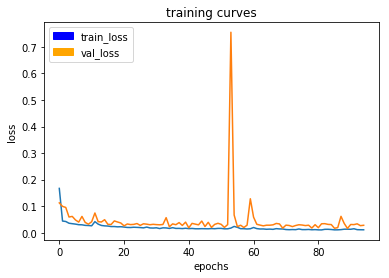

128/128 [==============================] - 55s - loss: 0.0110 - val_loss: 0.0279
Epoch 96/100
128/128 [==============================] - 55s - loss: 0.0101 - val_loss: 0.0291
Epoch 97/100
128/128 [==============================] - 55s - loss: 0.0101 - val_loss: 0.0291
Epoch 98/100
128/128 [==============================] - 56s - loss: 0.0118 - val_loss: 0.0224
Epoch 99/100
128/128 [==============================] - 56s - loss: 0.0121 - val_loss: 0.0281
Epoch 100/100
127/128 [============================>.] - ETA: 0s - loss: 0.0109

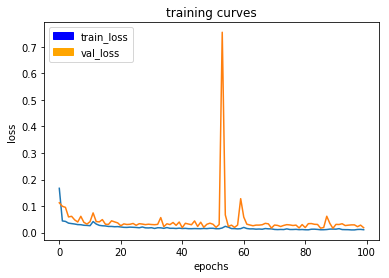

128/128 [==============================] - 56s - loss: 0.0109 - val_loss: 0.0184
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9964042623332636
average intersection over union for other people is 0.39710510321096815
average intersection over union for the hero is 0.9148367181866356
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9885861585987441
average intersection over union for other people is 0.7664482214717345
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 43, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969297974792407
average intersection over union for other people is 0.4731287061215

In [9]:
# Run Five
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.01
batch_size = 32
num_epochs = 100
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-5'
model_tools.save_network(model, weight_file_name)
score_all()

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [3]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights-5-2-115.h5'
model = model_tools.load_network(weight_file_name)

In [22]:
def score_all():
    run_num = 'run_1'

    val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 
    val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 
    val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')
    true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)
    true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)
    true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)
    true_pos = true_pos1 + true_pos2 + true_pos3
    false_pos = false_pos1 + false_pos2 + false_pos3
    false_neg = false_neg1 + false_neg2 + false_neg3

    weight = true_pos/(true_pos+false_neg+false_pos)
    print(weight)
    final_IoU = (iou1 + iou3)/2
    print(final_IoU)
    final_score = final_IoU * weight
    print(final_score)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [4]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

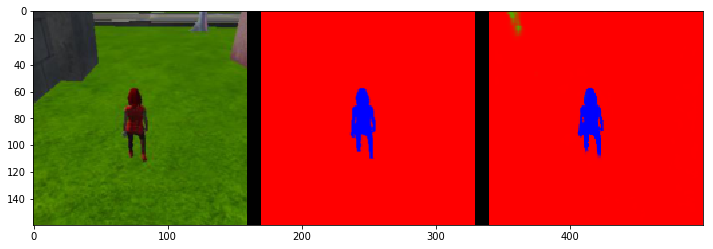

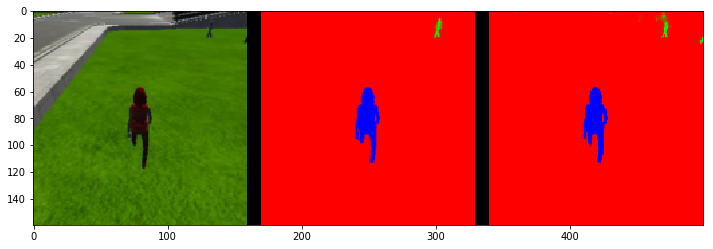

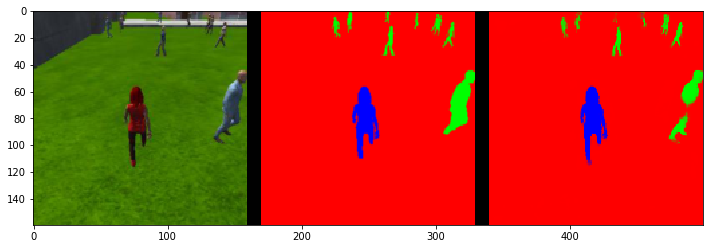

In [5]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

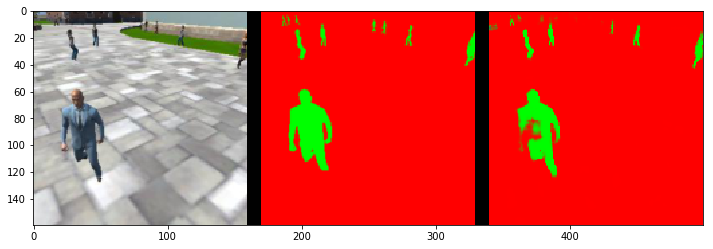

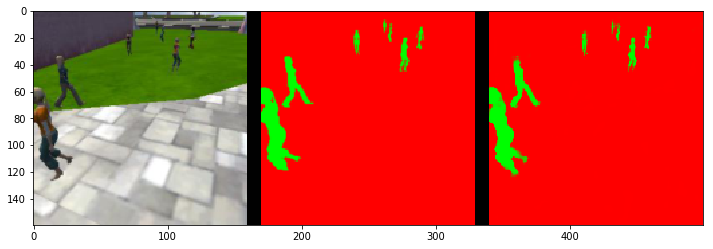

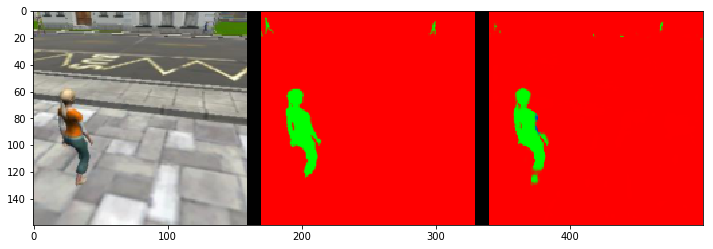

In [6]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

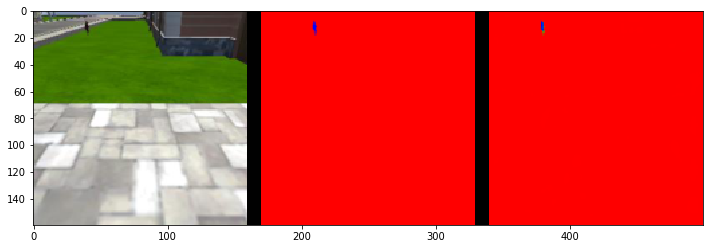

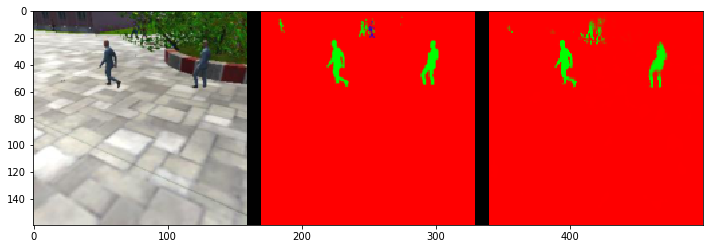

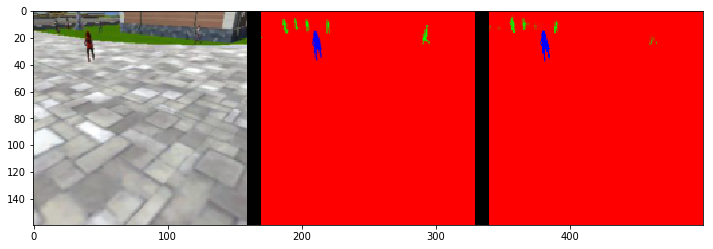

In [10]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9719131976476029
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 539


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.954649016203703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9897817595108703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 301


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.0


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.0


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.0


In [70]:
score_all()

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9963394576552786
average intersection over union for other people is 0.4056472576435936
average intersection over union for the hero is 0.9179279436394878
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9888125736978159
average intersection over union for other people is 0.7788583401332084
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 40, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9968766927429862
average intersection over union for other people is 0.48419467471686856
average intersection over union for the hero is 0.23063691190674876
number tr